In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import polars as pl
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import gc
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
gc.collect()

30

In [3]:
print("Czy GPU jestt : ", tf.config.list_physical_devices('GPU'))
import tensorflow as tf   # TensorFlow registers PluggableDevices here.
tf.config.list_physical_devices()

Czy GPU jestt :  []


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

### Pobranie przetworzonych danych

In [4]:
probka = pl.read_csv('.\\danonki\\1472_all_confidence.csv', n_rows=50, ignore_errors=True)
kolumny = probka.columns
reference_schema = probka.schema

def cast_to_reference_schema_special(df, reference_schema):
    return df.with_columns([
        # Jeśli docelowy typ to Int64, wykonaj najpierw cast na Float64, a potem na Int64
        pl.col(col_name).cast(pl.Float64).cast(pl.Int64) if reference_schema[col_name] == pl.Int64 
        else pl.col(col_name).cast(reference_schema[col_name])  # Dla pozostałych kolumn wykonaj zwykłe rzutowanie
        for col_name in df.columns if col_name in reference_schema
    ])


folder_path = '.\\danonki'
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

# Lista przechowująca przetworzone ramki danych
dane_lazy_frames = []
 
#Przetwarzanie plików
for i, path in enumerate(file_paths):
    print(f"Przetwarzanie pliku {i + 1}/{len(file_paths)}: {path}")

    # Lazy load ramki z rzutowaniem
    dane_lazy = (
        pl.scan_csv(path, ignore_errors=True)
    )

    dane_lazy = cast_to_reference_schema_special(dane_lazy, reference_schema)
 
    dane_lazy_frames.append(dane_lazy)

# Konkatenacja wszystkich ramek danych
dane_combined_lazy = pl.concat(dane_lazy_frames, how="vertical")

# Zmaterializowanie połączonych danych
final_data = dane_combined_lazy.collect()

Przetwarzanie pliku 1/11: .\danonki\1472_all_confidence.csv
Przetwarzanie pliku 2/11: .\danonki\2004_data_confidence.csv
Przetwarzanie pliku 3/11: .\danonki\2500_data_confidence.csv
Przetwarzanie pliku 4/11: .\danonki\2582_all_confidence.csv
Przetwarzanie pliku 5/11: .\danonki\4614_data_confidence.csv
Przetwarzanie pliku 6/11: .\danonki\4953_data_confidence.csv
Przetwarzanie pliku 7/11: .\danonki\5656_data_confidence.csv
Przetwarzanie pliku 8/11: .\danonki\6139_data_confidence.csv
Przetwarzanie pliku 9/11: .\danonki\6241_data_confidence.csv
Przetwarzanie pliku 10/11: .\danonki\6601_data_confidence.csv
Przetwarzanie pliku 11/11: .\danonki\6701_all_confidence.csv


C:\Users\user\AppData\Local\Temp\ipykernel_13396\3567989812.py:10: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  for col_name in df.columns if col_name in reference_schema


shape: (5_482_197, 103)
┌───────┬────────────┬────────────┬──────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ mr    ┆ patient_id ┆ chunk_numb ┆ frame_nr ┆ … ┆ pcm_fftMag ┆ pcm_fftMag ┆ pcm_fftMa ┆ pcm_fftMa │
│ ---   ┆ ---        ┆ er         ┆ ---      ┆   ┆ _mfcc_9_   ┆ _mfcc_10_  ┆ g_mfcc_11 ┆ g_mfcc_12 │
│ i64   ┆ i64        ┆ ---        ┆ i64      ┆   ┆ ---        ┆ ---        ┆ _         ┆ _         │
│       ┆            ┆ i64        ┆          ┆   ┆ f64        ┆ f64        ┆ ---       ┆ ---       │
│       ┆            ┆            ┆          ┆   ┆            ┆            ┆ f64       ┆ f64       │
╞═══════╪════════════╪════════════╪══════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 5857  ┆ 1472       ┆ 0          ┆ 1        ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0       ┆ 0.0       │
│ 5857  ┆ 1472       ┆ 0          ┆ 2        ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0       ┆ 0.0       │
│ 5857  ┆ 1472       ┆ 0          ┆ 3        ┆ … ┆ 0.0        ┆ 0.0

In [5]:
probka = pl.read_csv('.\\danonki\\1472_all_confidence.csv', n_rows=50, ignore_errors=True)
kolumny = probka.columns
reference_schema = probka.schema

def cast_to_reference_schema_special(df, reference_schema):
    return df.with_columns([
        # Jeśli docelowy typ to Int64, wykonaj najpierw cast na Float64, a potem na Int64
        pl.col(col_name).cast(pl.Float64).cast(pl.Int64) if reference_schema[col_name] == pl.Int64 
        else pl.col(col_name).cast(reference_schema[col_name])  # Dla pozostałych kolumn wykonaj zwykłe rzutowanie
        for col_name in df.columns if col_name in reference_schema
    ])


folder_path = '.\\danonki2'
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

# Lista przechowująca przetworzone ramki danych
dane_lazy_frames = []
 
#Przetwarzanie plików
for i, path in enumerate(file_paths):
    print(f"Przetwarzanie pliku {i + 1}/{len(file_paths)}: {path}")

    # Lazy load ramki z rzutowaniem
    dane_lazy = (
        pl.scan_csv(path, ignore_errors=True)
    )

    dane_lazy = cast_to_reference_schema_special(dane_lazy, reference_schema)
 
    dane_lazy_frames.append(dane_lazy)

# Konkatenacja wszystkich ramek danych
dane_combined_lazy2 = pl.concat(dane_lazy_frames, how="vertical")

# Zmaterializowanie połączonych danych
final_data2 = dane_combined_lazy2.collect()

Przetwarzanie pliku 1/13: .\danonki2\0681_data_confidence.csv
Przetwarzanie pliku 2/13: .\danonki2\1153_data_confidence.csv
Przetwarzanie pliku 3/13: .\danonki2\1981_all_confidence.csv
Przetwarzanie pliku 4/13: .\danonki2\6754_data_confidence.csv
Przetwarzanie pliku 5/13: .\danonki2\7297_data_confidence.csv
Przetwarzanie pliku 6/13: .\danonki2\7379_data_confidence.csv
Przetwarzanie pliku 7/13: .\danonki2\8193_data_confidence.csv
Przetwarzanie pliku 8/13: .\danonki2\8281_data_confidence.csv
Przetwarzanie pliku 9/13: .\danonki2\8560_all_confidence.csv
Przetwarzanie pliku 10/13: .\danonki2\8779_data_confidence.csv
Przetwarzanie pliku 11/13: .\danonki2\8866_data_confidence.csv
Przetwarzanie pliku 12/13: .\danonki2\9813_data_confidence.csv
Przetwarzanie pliku 13/13: .\danonki2\9829_data_confidence.csv


C:\Users\user\AppData\Local\Temp\ipykernel_13396\2070821668.py:10: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  for col_name in df.columns if col_name in reference_schema


shape: (3_015_092, 103)
┌───────┬────────────┬────────────┬──────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ mr    ┆ patient_id ┆ chunk_numb ┆ frame_nr ┆ … ┆ pcm_fftMag ┆ pcm_fftMag ┆ pcm_fftMa ┆ pcm_fftMa │
│ ---   ┆ ---        ┆ er         ┆ ---      ┆   ┆ _mfcc_9_   ┆ _mfcc_10_  ┆ g_mfcc_11 ┆ g_mfcc_12 │
│ i64   ┆ i64        ┆ ---        ┆ i64      ┆   ┆ ---        ┆ ---        ┆ _         ┆ _         │
│       ┆            ┆ i64        ┆          ┆   ┆ f64        ┆ f64        ┆ ---       ┆ ---       │
│       ┆            ┆            ┆          ┆   ┆            ┆            ┆ f64       ┆ f64       │
╞═══════╪════════════╪════════════╪══════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 25263 ┆ 681        ┆ 0          ┆ 1        ┆ … ┆ -12.87781  ┆ -1.392209  ┆ 2.959874  ┆ 40.61887  │
│ 25263 ┆ 681        ┆ 0          ┆ 2        ┆ … ┆ 3.042789   ┆ -8.854153  ┆ -7.27696  ┆ 47.30368  │
│ 25263 ┆ 681        ┆ 0          ┆ 3        ┆ … ┆ 7.335399   ┆ 4.5

In [6]:
del dane_combined_lazy, dane_combined_lazy2 , dane_lazy, dane_lazy_frames, file_paths, folder_path, i, kolumny, path, reference_schema

In [7]:
df = pl.concat([final_data, final_data2], how="vertical")

In [24]:
del final_data, final_data2

In [10]:
# df.group_by(["label"]).agg(pl.col("label").count().alias("count"))

label,count
str,u32
"""depression""",1923498
"""euthymia""",1030844
"""mixed""",637869
"""mania""",1093569


In [8]:
df.group_by(["label"]).agg(pl.col("label").count().alias("count"))

label,count
str,u32
"""depression""",2385416
"""euthymia""",3798750
"""mixed""",1085154
"""mania""",1227969


In [9]:
df = df.fill_null(0)

## Przygotowanie pod sieć CNN

### Encoding danych

In [10]:
start_idx = df.columns.index('pcm_LOGenergy_sma')
end_idx = df.columns.index('pcm_fftMag_mfcc_12_')
    
# Select specific columns along with the dynamically sliced columns
feature_columns = df.select(df.columns[start_idx:end_idx+1 ]).columns

In [27]:
df.head(3)

mr,patient_id,chunk_number,frame_nr,create_date,date,visit_date,time_point,label,chunks_count,euthymia,depression,mania,mixed,confidence_gauss,confidence_linear,confidence_constant,pcm_LOGenergy_sma,pcm_zcr_sma,voiceprob_sma,f0_sma,f0env_sma,pcm_fftMag_fband0-250_sma,pcm_fftMag_fband0-650_sma,pcm_fftMag_spectralRollOff25_0_sma,pcm_fftMag_spectralRollOff50_0_sma,pcm_fftMag_spectralRollOff75_0_sma,pcm_fftMag_spectralRollOff90_0_sma,pcm_fftmag_spectralflux_sma,pcm_fftmag_spectralcentroid_sma,pcm_fftmag_spectralmaxpos_sma,pcm_fftmag_spectralminpos_sma,f0final_sma,voicingfinalunclipped_sma,jitterlocal_sma,jitterddp_sma,shimmerlocal_sma,…,audSpec_Rfilt_sma_compare_25_,pcm_fftMag_fband250-650_sma_compare,pcm_fftMag_fband1000-4000_sma_compare,pcm_fftmag_spectralentropy_sma_compare,pcm_fftmag_spectralvariance_sma_compare,pcm_fftmag_spectralskewness_sma_compare,pcm_fftmag_spectralkurtosis_sma_compare,pcm_fftmag_psysharpness_sma_compare,pcm_fftmag_spectralharmonicity_sma_compare,loudness_sma3,alpharatio_sma3,hammarbergindex_sma3,slope0-500_sma3,slope500-1500_sma3,F0semitoneFrom27_5Hz_sma3nz,logRelF0-H1-H2_sma3nz,logRelF0-H1-A3_sma3nz,f1frequency_sma3nz,f1bandwidth_sma3nz,f1amplitudelogrelf0_sma3nz,f2frequency_sma3nz,f2amplitudelogrelf0_sma3nz,f3frequency_sma3nz,f3amplitudelogrelf0_sma3nz,pcm_fftMag_mfcc_0_,pcm_fftMag_mfcc_1_,pcm_fftMag_mfcc_2_,pcm_fftMag_mfcc_3_,pcm_fftMag_mfcc_4_,pcm_fftMag_mfcc_5_,pcm_fftMag_mfcc_6_,pcm_fftMag_mfcc_7_,pcm_fftMag_mfcc_8_,pcm_fftMag_mfcc_9_,pcm_fftMag_mfcc_10_,pcm_fftMag_mfcc_11_,pcm_fftMag_mfcc_12_
i64,i64,i64,i64,str,str,str,i64,str,i64,i64,i64,i64,i64,f64,f64,i64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,i64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
5857,1472,0,1,"""2018-03-21 14:19:29""","""2018-03-21""","""2018-03-28""",-7,"""mixed""",3,0,0,0,1,2.2897e-11,0.3,1,-41.58871,0.99,0.0,0,0,0.0,0.0,31.25,31.25,31.25,31.25,0.0,0.0,31.25,31.25,0,0,0,0,0,…,1.448623,0.0,0.0,0.000002,0.0,0.0,0.0,0.0,0.0,0.001017,0.0,0.0,0.112,0.076364,0,0,0,0.0,0.0,-201,0.0,-201,0.0,-201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5857,1472,0,2,"""2018-03-21 14:19:29""","""2018-03-21""","""2018-03-28""",-7,"""mixed""",3,0,0,0,1,2.2897e-11,0.3,1,-41.58871,0.99,0.0,0,0,0.0,0.0,31.25,31.25,31.25,31.25,0.0,0.0,31.25,31.25,0,0,0,0,0,…,1.448623,0.0,0.0,0.000002,0.0,0.0,0.0,0.0,0.0,0.001017,0.0,0.0,0.112,0.076364,0,0,0,0.0,0.0,-201,0.0,-201,0.0,-201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5857,1472,0,3,"""2018-03-21 14:19:29""","""2018-03-21""","""2018-03-28""",-7,"""mixed""",3,0,0,0,1,2.2897e-11,0.3,1,-41.58871,0.99,0.0,0,0,0.0,0.0,31.25,31.25,31.25,31.25,0.0,0.0,31.25,31.25,0,0,0,0,0,…,1.448623,0.0,0.0,0.000002,0.0,0.0,0.0,0.0,0.0,0.001017,0.0,0.0,0.112,0.076364,0,0,0,0.0,0.0,-201,0.0,-201,0.0,-201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
train = df.filter(pl.col('time_point') != 0)
test = df.filter(pl.col('time_point') == 0)

# X_train = train.select(feature_columns)
# X_test = test.select(feature_columns)
# X_train_weight = train.select('confidence_gauss')
# X_test_weight = test.select('confidence_gauss')

# y_train_int = train.select('label')
# y_test_int= test.select('label')

In [49]:
grouped_train = train.partition_by('mr')
grouped_test = test.partition_by('mr')

In [53]:
train_weight

[shape: (1,)
 Series: 'confidence_linear' [f64]
 [
 	0.3
 ]]

In [54]:
train_arrays = []
train_y = []
train_weight = []
max_frames = 2000  # Desired number of frames per conversation

for group in grouped_train:
    # Sort frames
    group_sorted = group.sort('frame_nr')  # or 'chunk_number'
    features = group_sorted.select(feature_columns).to_numpy()

    # Handle variable frame lengths
    num_frames = features.shape[0]
    if num_frames > max_frames:
        # Truncate
        features = features[:max_frames, :]
    elif num_frames < max_frames:
        # Pad with zeros
        padding = np.zeros((max_frames - num_frames, features.shape[1]))
        features = np.vstack((features, padding))

    train_arrays.append(features)
    train_y.append(group_sorted["label"].explode().unique())
    train_weight.append(group_sorted["confidence_linear"].explode().unique())

In [55]:
test_arrays = []
test_y = []
test_weight = []
max_frames = 2000  # Desired number of frames per conversation

for group in grouped_test:
    # Sort frames
    group_sorted = group.sort('frame_nr')  # or 'chunk_number'

    # Extract feature values as a NumPy array
    features = group_sorted.select(feature_columns).to_numpy()

    # Handle variable frame lengths
    num_frames = features.shape[0]
    if num_frames > max_frames:
        # Truncate
        features = features[:max_frames, :]
    elif num_frames < max_frames:
        # Pad with zeros
        padding = np.zeros((max_frames - num_frames, features.shape[1]))
        features = np.vstack((features, padding))

    test_arrays.append(features)
    test_y.append(group_sorted["label"].explode().unique())
    test_weight.append(group_sorted["confidence_linear"].explode().unique())

In [56]:
# Final input array of shape (num_conversations, max_frames, num_features)
X_train = np.stack(train_arrays)
X_test = np.stack(test_arrays)

In [72]:
Y_train = np.stack(train_y)
Y_test = np.stack(test_y)
Y_train

array([['mixed'],
       ['mixed'],
       ['mixed'],
       ...,
       ['depression'],
       ['depression'],
       ['depression']], dtype='<U10')

In [73]:
label_mapping = {
    'euthymia': 0,
    'depression': 1,
    'mania': 2,
    'mixed': 3
}

vectorized_mapping = np.vectorize(label_mapping.get)
Y_train = vectorized_mapping(Y_train)
Y_test = vectorized_mapping(Y_test)
Y_train
#Y_train = np.array([label_mapping[label] for label in Y_train])

array([[3],
       [3],
       [3],
       ...,
       [1],
       [1],
       [1]])

In [61]:
X_train_weight = np.stack(train_weight)
X_test_weight = np.stack(test_weight)

In [89]:
# Convert integer labels to one-hot encoded vectors
Y_train = to_categorical(Y_train, num_classes=4)
Y_test = to_categorical(Y_test, num_classes=4)



In [80]:
Y_train

array([[3],
       [3],
       [3],
       ...,
       [1],
       [1],
       [1]])

In [76]:
X_train

array([[[-4.158871e+01,  9.900000e-01,  0.000000e+00, ...,
          0.000000e+00,  0.000000e+00,  0.000000e+00],
        [-4.158871e+01,  9.900000e-01,  0.000000e+00, ...,
          0.000000e+00,  0.000000e+00,  0.000000e+00],
        [-4.158871e+01,  9.900000e-01,  0.000000e+00, ...,
          0.000000e+00,  0.000000e+00,  0.000000e+00],
        ...,
        [-2.212170e+01,  2.950000e-01,  2.838966e-01, ...,
          5.166525e+00,  6.207182e-01,  3.173641e+01],
        [-2.221821e+01,  2.733333e-01,  2.940682e-01, ...,
          3.346417e+00, -6.015238e+00,  3.365155e+01],
        [-2.214262e+01,  2.816667e-01,  2.470831e-01, ...,
         -1.644218e+01, -1.083421e-01,  3.664929e+01]],

       [[-4.158871e+01,  9.900000e-01,  0.000000e+00, ...,
          0.000000e+00,  0.000000e+00,  0.000000e+00],
        [-4.158871e+01,  9.900000e-01,  0.000000e+00, ...,
          0.000000e+00,  0.000000e+00,  0.000000e+00],
        [-4.158871e+01,  9.900000e-01,  0.000000e+00, ...,
          0.00

In [82]:
scaler = StandardScaler()
#X_train
X_train_scaled_flat = X_train.reshape(-1, X_train.shape[-1])
X_train_scaled_flat =  scaler.fit_transform(X_train_scaled_flat)
X_train_scaled = X_train_scaled_flat.reshape(X_train.shape)

#X_test
X_test_scaled_flat = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled_flat =  scaler.fit_transform(X_test_scaled_flat)
X_test_scaled = X_test_scaled_flat.reshape(X_test.shape)

#Y_train_flat = Y_train.reshape(-1)
#Y_test_flat = Y_test.reshape(-1)

Y_train_flat = np.repeat(Y_train, X_train.shape[1])  # X_train.shape[1] = 1000
Y_test_flat = np.repeat(Y_test, X_test.shape[1])

In [ ]:
# Flatten X_train and X_test
# X_train shape: (1418, 1000, 86) -> (1418000, 86)
# X_train_flat = X_train.reshape(-1, X_train.shape[-1])
# X_test_flat = X_test.reshape(-1, X_test.shape[-1])

# Scale the flattened X data
# scaler_X = StandardScaler()
# X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
# X_test_scaled_flat = scaler_X.transform(X_test_flat)

# # Flatten y_train_int and y_test_int
# # Assuming y_train_int shape: (1418, 1000) -> (1418000,)
# y_train_flat = y_train_int.reshape(-1)
# y_test_flat = y_test_int.reshape(-1)

# # Reshape y to 2D arrays for scaling
# y_train_flat = y_train_flat.reshape(-1, 1)
# y_test_flat = y_test_flat.reshape(-1, 1)

# # Scale y values
# scaler_y = StandardScaler()
# y_train_scaled_flat = scaler_y.fit_transform(y_train_flat)
# y_test_scaled_flat = scaler_y.transform(y_test_flat)

# # Optionally, flatten y back to 1D arrays (if needed)
# y_train_scaled_flat = y_train_scaled_flat.flatten()
# y_test_scaled_flat = y_test_scaled_flat.flatten()

# y_train_flat = np.repeat(y_train_int, X_train.shape[1])  # X_train.shape[1] = 1000
# y_test_flat = np.repeat(y_test_int, X_test.shape[1])

# # Reshape y to 2D arrays for scaling
# y_train_flat = y_train_flat.reshape(-1, 1)
# y_test_flat = y_test_flat.reshape(-1, 1)

# # Flatten and scale training data
# X_train_flat = X_train.reshape(-1, X_train.shape[-1])
# scaler = StandardScaler()
# X_train_scaled_flat = scaler.fit_transform(X_train_flat)
# X_train_scaled = X_train_scaled_flat.reshape(X_train.shape)

# # Flatten and scale test data
# X_test_flat = X_test.reshape(-1, X_test.shape[-1])
# X_test_scaled_flat = scaler.transform(X_test_flat)
# X_test_scaled = X_test_scaled_flat.reshape(X_test.shape)

In [75]:
num_features = X_train.shape[2]
num_classes = 4
num_features

86

## CNN

## CNN + LSTM

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout,Flatten

# Budowa modelu CNN + LSTM
model = Sequential()

# Convolutional layers to extract local features
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                 input_shape=(max_frames, num_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layer to capture temporal dependencies
model.add(LSTM(64))

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes, activation='softmax'))



In [90]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train_scaled, Y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_scaled, Y_test),
    callbacks=[early_stopping],
    sample_weight = X_train_weight      
)

Epoch 1/10
87/87 [==============================] - 38s 411ms/step - loss: 0.5679 - accuracy: 0.3852 - val_loss: 1.1634 - val_accuracy: 0.3708
Epoch 2/10
87/87 [==============================] - 35s 406ms/step - loss: 0.5146 - accuracy: 0.4189 - val_loss: 1.1787 - val_accuracy: 0.4178
Epoch 3/10
87/87 [==============================] - 36s 417ms/step - loss: 0.5039 - accuracy: 0.4287 - val_loss: 1.1857 - val_accuracy: 0.4073
Epoch 4/10
87/87 [==============================] - 35s 407ms/step - loss: 0.4919 - accuracy: 0.4334 - val_loss: 1.2044 - val_accuracy: 0.3681
Epoch 5/10
87/87 [==============================] - 35s 406ms/step - loss: 0.4794 - accuracy: 0.4573 - val_loss: 1.1818 - val_accuracy: 0.4047
Epoch 6/10
87/87 [==============================] - 36s 408ms/step - loss: 0.4526 - accuracy: 0.4479 - val_loss: 1.3440 - val_accuracy: 0.3838
Epoch 7/10
87/87 [==============================] - 35s 408ms/step - loss: 0.4458 - accuracy: 0.4815 - val_loss: 1.2241 - val_accuracy: 0.4334

In [91]:
test_loss, test_accuracy = model.evaluate(X_test_scaled, Y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

12/12 [==============================] - 1s 99ms/step - loss: 1.2801 - accuracy: 0.3916
Test Loss: 1.2801
Test Accuracy: 0.3916


In [92]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train_scaled, Y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_scaled, Y_test),
    callbacks=[early_stopping]   
)
test_loss, test_accuracy = model.evaluate(X_test_scaled, Y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/10
87/87 [==============================] - 40s 428ms/step - loss: 0.9811 - accuracy: 0.5746 - val_loss: 1.1033 - val_accuracy: 0.4935
Epoch 2/10
87/87 [==============================] - 36s 409ms/step - loss: 0.9076 - accuracy: 0.6169 - val_loss: 1.0405 - val_accuracy: 0.5614
Epoch 3/10
87/87 [==============================] - 35s 407ms/step - loss: 0.8812 - accuracy: 0.6322 - val_loss: 1.0421 - val_accuracy: 0.5326
Epoch 4/10
87/87 [==============================] - 36s 409ms/step - loss: 0.8461 - accuracy: 0.6513 - val_loss: 1.0363 - val_accuracy: 0.5796
Epoch 5/10
87/87 [==============================] - 35s 406ms/step - loss: 0.8081 - accuracy: 0.6673 - val_loss: 1.1121 - val_accuracy: 0.5300
Epoch 6/10
87/87 [==============================] - 36s 408ms/step - loss: 0.7702 - accuracy: 0.6904 - val_loss: 1.0870 - val_accuracy: 0.5509
Epoch 7/10
87/87 [==============================] - 35s 407ms/step - loss: 0.7523 - accuracy: 0.6970 - val_loss: 0.9619 - val_accuracy: 0.6188

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict classes for the test set
y_pred_probs = model.predict(X_test_scaled)
y_pred_int = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test_int, y_pred_int)
print('Confusion Matrix:')
print(cm)

12/12 [==============================] - 1s 57ms/step
Confusion Matrix:
[[23 31 27  0]
 [24 89 23  1]
 [23 11 56  1]
 [ 6  5  7 28]]


In [93]:
report = classification_report(y_test_int, y_pred_int, target_names=['Euthymia', 'Depression', 'Mania', 'Mixed'])
print('Classification Report:')
print(report)

NameError: name 'y_pred_int' is not defined

## Ulepszanie sieci

In [94]:
import os
import random
import numpy as np
import tensorflow as tf

# 1. Ustawienie zmiennych środowiskowych
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# (Opcjonalnie) Wyłączenie GPU dla pełnej reprodukowalności
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# 2. Ustawienie ziarna dla modułu random
random.seed(42)

# 3. Ustawienie ziarna dla NumPy
np.random.seed(42)

# 4. Ustawienie ziarna dla TensorFlow
tf.random.set_seed(42)

# 5. Konfiguracja wątków w TensorFlow
#tf.config.threading.set_inter_op_parallelism_threads(1)
#tf.config.threading.set_intra_op_parallelism_threads(1)

In [95]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Przygotowanie danych (przykładowo)
# Upewnij się, że zmienne X_train_scaled, y_train, X_test_scaled, y_test, max_frames, num_features, num_classes są zdefiniowane




tf.random.set_seed(42)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def build_model_with_L2():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', #tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', 
                               input_shape=(max_frames, num_features),
                               kernel_regularizer=regularizers.l2(0.02)), #kernel_regularizer=regularizers.l2(0.05)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=512, kernel_size=3, activation='relu', #tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', 
                               kernel_regularizer=regularizers.l2(0.02)), #kernel_regularizer=regularizers.l2(0.05)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.LSTM(128), #tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.02)), #tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.05)),
        tf.keras.layers.Dropout(0.5), #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



def build_model_with_Residual_CNN():
    inputs = tf.keras.Input(shape=(max_frames, num_features))
    
    # Blok 1
    x = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(inputs) #x = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x) #x = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    
    residual = x  # Zapisujemy tensor do późniejszego użycia
    
    # Blok 2
    x = tf.keras.layers.Conv1D(128, kernel_size=3, padding='same', activation='relu')(x) #x = tf.keras.layers.Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv1D(128, kernel_size=3, padding='same', activation='relu')(x) #x = tf.keras.layers.Conv1D(256, kernel_size=3, padding='same', activation='relu')(x)
    
    # Dostosowanie liczby kanałów w residual do x
    residual = tf.keras.layers.Conv1D(128, kernel_size=1, padding='same')(residual) #residual = tf.keras.layers.Conv1D(128, kernel_size=1, padding='same')(residual)
    
    # Dodanie połączenia resztkowego
    x = tf.keras.layers.Add()([x, residual])
    x = tf.keras.layers.Activation('relu')(x)  # Opcjonalnie dodaj aktywację po dodaniu
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    
    # Blok końcowy
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x) #x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x) #x = tf.keras.layers.Dropout(0.2)(x)
    
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_model_with_Residual_CNN2():
    inputs = tf.keras.Input(shape=(max_frames, num_features))
    
    # Blok 1
    x = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation=None)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)  
    
    x = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)  
    
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    
    residual = x  # Zapisujemy tensor do późniejszego użycia
    
    # Blok 2
    x = tf.keras.layers.Conv1D(128, kernel_size=3, padding='same', activation=None,
                           kernel_regularizer=regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)  
    
    x = tf.keras.layers.Conv1D(128, kernel_size=3, padding='same', activation=None,
                           kernel_regularizer=regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)  
    
    # Dostosowanie liczby kanałów w residual do x
    residual = tf.keras.layers.Conv1D(128, kernel_size=1, padding='same', activation=None,
                           kernel_regularizer=regularizers.l2(0.001))(residual)
    residual = tf.keras.layers.BatchNormalization()(residual)
    # W połączeniu resztkowym zwykle nie stosuje się funkcji aktywacji

    # Dodanie połączenia resztkowego
    x = tf.keras.layers.Add()([x, residual])
    x = tf.keras.layers.Activation('relu')(x)   
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    
    # Blok końcowy
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    x = tf.keras.layers.Dense(64, activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('leaky_relu')(x) 
    x = tf.keras.layers.Dropout(0.1)(x) #x = tf.keras.layers.Dropout(0.1)(x)
    
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_model_with_Stacked_LSTM():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', 
                               input_shape=(max_frames, num_features)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        
        tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        
        tf.keras.layers.LSTM(256, return_sequences=True), #tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.LSTM(128), #tf.keras.layers.LSTM(64),
        
        tf.keras.layers.Dense(128, activation='relu'), #tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

def build_basic_cnn():
    model = models.Sequential([
        # Warstwa konwolucyjna 1
        layers.Conv1D(filters=32, kernel_size=3, activation='relu', 
                      input_shape=(max_frames, num_features)),
        layers.MaxPooling1D(pool_size=2),

        # Warstwa konwolucyjna 2
        layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),

        # Spłaszczenie i warstwy gęste
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),

        # Warstwa wyjściowa
        layers.Dense(num_classes, activation='softmax')
    ])

    # Kompilacja modelu
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
# Słownik funkcji budujących modele
model_builders = {
    #'Model_L2': build_model_with_L2, 
    'Model_CNN' : build_basic_cnn,
    'Model_Residual_CNN': build_model_with_Residual_CNN ,
    'Model_Residual_CNN2': build_model_with_Residual_CNN2 ,
    'Model_Stacked_LSTM': build_model_with_Stacked_LSTM 
   
}

Training Model_CNN...
Epoch 1/10
87/87 [==============================] - 9s 95ms/step - loss: 1.6049 - accuracy: 0.3972 - val_loss: 1.1447 - val_accuracy: 0.4648
Epoch 2/10
87/87 [==============================] - 8s 87ms/step - loss: 1.1643 - accuracy: 0.4718 - val_loss: 1.0975 - val_accuracy: 0.5379
Epoch 3/10
87/87 [==============================] - 7s 83ms/step - loss: 1.0492 - accuracy: 0.5141 - val_loss: 0.9709 - val_accuracy: 0.6162
Epoch 4/10
87/87 [==============================] - 7s 79ms/step - loss: 0.9396 - accuracy: 0.5724 - val_loss: 0.8889 - val_accuracy: 0.6554
Epoch 5/10
87/87 [==============================] - 8s 89ms/step - loss: 0.8050 - accuracy: 0.6481 - val_loss: 0.9117 - val_accuracy: 0.6188
Epoch 6/10
87/87 [==============================] - 7s 82ms/step - loss: 0.7245 - accuracy: 0.6760 - val_loss: 0.8788 - val_accuracy: 0.6554
Epoch 7/10
87/87 [==============================] - 7s 85ms/step - loss: 0.6327 - accuracy: 0.7252 - val_loss: 0.9835 - val_accuracy

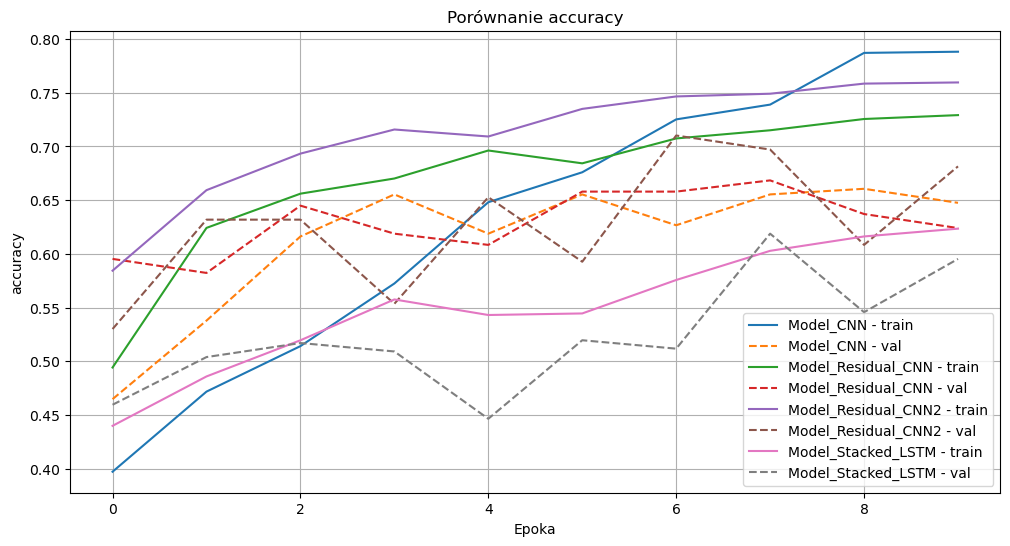

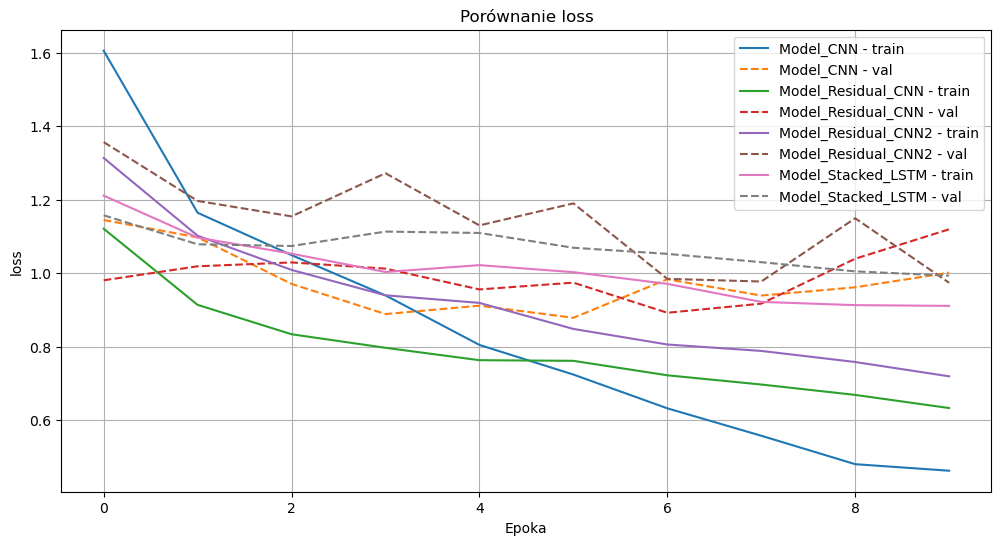

In [96]:
import os
import random
import numpy as np

# 1. Ustawienie zmiennych środowiskowych
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# 2. Ustawienie ziarna losowego dla modułów random i NumPy
random.seed(42)
np.random.seed(42)

# 3. Import TensorFlow
import tensorflow as tf

# 4. Ustawienie konfiguracji wątków
#tf.config.threading.set_inter_op_parallelism_threads(1)
#tf.config.threading.set_intra_op_parallelism_threads(1)

# 5. Ustawienie ziarna losowego dla TensorFlow
tf.random.set_seed(42)

# 6. Importowanie modułów Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten


histories = {}
trained_models = {}


for model_name, build_function in model_builders.items():
    print(f'Training {model_name}...')
    tf.random.set_seed(42)
    model = build_function()
    history = model.fit(
        X_train_scaled, Y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test_scaled, Y_test),
        callbacks=[early_stopping],
        verbose=1  # Ustaw na 1, jeśli chcesz zobaczyć postęp treningu
    )
    histories[model_name] = history
    trained_models[model_name] = model  # Zapisujemy wytrenowany model
    print(f'{model_name} training completed.')

def plot_metric(histories, metric):
    plt.figure(figsize=(12, 6))
    
    for model_name, history in histories.items():
        plt.plot(history.history[metric], label=f'{model_name} - train')
        plt.plot(history.history[f'val_{metric}'], linestyle='--', label=f'{model_name} - val')
    
    plt.title(f'Porównanie {metric}')
    plt.xlabel('Epoka')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric(histories, 'accuracy')
plot_metric(histories, 'loss')

In [97]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import numpy as np


metrics_list = []

for model_name, model in trained_models.items():
    print(f'Evaluating {model_name}...')
    # Ocena modelu na zbiorze testowym
    loss, accuracy = model.evaluate(X_test_scaled, Y_test, verbose=0)
    
    # Przewidywania na zbiorze testowym
    y_pred_probs = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(Y_test, axis=1)
    
    # Obliczanie precyzji, recall, F1-score
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    # Dodanie metryk do listy
    metrics_list.append({
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Loss': round(loss, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-score': round(f1, 4)
    })

# Tworzenie DataFrame z metrykami
metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index('Model', inplace=True)

# Wyświetlenie tabeli
print(metrics_df)

Evaluating Model_CNN...
12/12 [==============================] - 0s 17ms/step
Evaluating Model_Residual_CNN...
12/12 [==============================] - 1s 75ms/step
Evaluating Model_Residual_CNN2...
12/12 [==============================] - 1s 78ms/step
Evaluating Model_Stacked_LSTM...
12/12 [==============================] - 6s 383ms/step
                     Accuracy    Loss  Precision  Recall  F1-score
Model                                                             
Model_CNN              0.6475  1.0015     0.6418  0.6475    0.6393
Model_Residual_CNN     0.6240  1.1194     0.6391  0.6240    0.6231
Model_Residual_CNN2    0.6815  0.9739     0.6847  0.6815    0.6822
Model_Stacked_LSTM     0.5953  0.9933     0.6429  0.5953    0.5775


In [43]:
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Znalezienie indeksów błędnie sklasyfikowanych próbek
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]

# Wyświetlenie kilku błędnie sklasyfikowanych przykładów
for index in misclassified_indices[:5]:
    print(f'Indeks: {index}')
    print(f'Prawdziwa klasa: {y_true_classes[index]}')
    print(f'Przewidziana klasa: {y_pred_classes[index]}')
    # Możesz tutaj dodać kod do wizualizacji lub analizy danych wejściowych

12/12 [==============================] - 2s 193ms/step
Indeks: 4
Prawdziwa klasa: 0
Przewidziana klasa: 2
Indeks: 5
Prawdziwa klasa: 2
Przewidziana klasa: 3
Indeks: 11
Prawdziwa klasa: 0
Przewidziana klasa: 2
Indeks: 12
Prawdziwa klasa: 2
Przewidziana klasa: 0
Indeks: 18
Prawdziwa klasa: 0
Przewidziana klasa: 2


12/12 [==============================] - 2s 191ms/step


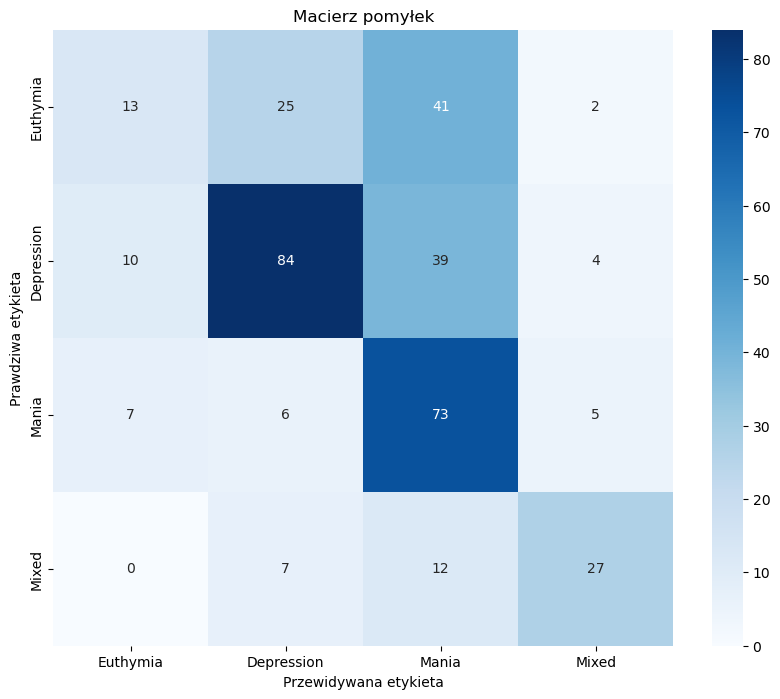

In [45]:
import seaborn as sns
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Prawdziwe etykiety
# Jeśli y_test jest one-hot encoded
y_true_classes = np.argmax(y_test, axis=1)

 

# Jeśli nie używasz LabelEncoder, zdefiniuj nazwy klas ręcznie
class_names = ['Euthymia', 'Depression', 'Mania', 'Mixed' ]  # Zastąp odpowiednimi nazwami

# Obliczenie macierzy pomyłek
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywana etykieta')
plt.ylabel('Prawdziwa etykieta')
plt.show()

## PLENARY

### Przygotowanie danych

In [ ]:
# df_train = pd.read_csv("df_train_noise.csv")
# df_test = pd.read_csv("df_test_noise.csv")

In [ ]:
# #TRAIN SET
# X_train = df_train.loc[:, 'pcm_LOGenergy_sma':'pcm_fftMag_mfcc_12_']
# y_train_symptoms = df_train.loc[:, 'anxiety':'suicide']
# y_train_states = df_train.loc[:, 'hamd_ymrs']

# # from categorical to numeric target
# label_coding = {'euthymia' : 0,
#                 'depression' : 1,
#                 'mania' : 2,
#                 'mixed': 3}

# y_train_states_encoded = np.array(y_train_states.map(label_coding).astype(int))

# # #TEST SET
# X_test = df_test.loc[:, 'pcm_LOGenergy_sma':'pcm_fftMag_mfcc_12_']
# y_test_symptoms = df_test.loc[:, 'anxiety':'suicide']
# y_test_states = df_test.loc[:, 'hamd_ymrs']

# y_test_states_encoded = np.array(y_test_states.map(label_coding).astype(int))

# # # standardize data
# scaler = preprocessing.StandardScaler()
# scaler.fit(X_train.values)
# X_train_scaled = scaler.transform(X_train.values)
# X_test_scaled = scaler.transform(X_test.values)

### Baseline

In [47]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, input_shape=(86,), activation='relu', name='dense'),
        tf.keras.layers.Dropout(0.2, name='dropout'),
        tf.keras.layers.Dense(4, activation='softmax', name='output')])
    model.build()
    return model

model_name = "baseline"
baseline = build_model()

baseline.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                5568      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 output (Dense)              (None, 4)                 260       
                                                                 
Total params: 5,828
Trainable params: 5,828
Non-trainable params: 0
_________________________________________________________________


In [51]:
baseline.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) 

baseline.fit(X_train_scaled_flat,
 y_train_flat,
 epochs=10,
 validation_data=(X_test_scaled_flat, y_test_flat),
 callbacks=[early_stopping])

y_pred_states = baseline.predict(X_test_scaled_flat)
y_pred_states = np.argmax(y_pred_states, axis=1)

Epoch 1/10
44313/44313 [==============================] - 137s 3ms/step - loss: 0.9888 - accuracy: 0.5548 - val_loss: 1.0284 - val_accuracy: 0.5423
Epoch 2/10
44313/44313 [==============================] - 132s 3ms/step - loss: 0.9646 - accuracy: 0.5652 - val_loss: 1.0196 - val_accuracy: 0.5485
Epoch 3/10
44313/44313 [==============================] - 128s 3ms/step - loss: 0.9575 - accuracy: 0.5681 - val_loss: 1.0204 - val_accuracy: 0.5461
Epoch 4/10
44313/44313 [==============================] - 124s 3ms/step - loss: 0.9536 - accuracy: 0.5704 - val_loss: 1.0134 - val_accuracy: 0.5506
Epoch 5/10
44313/44313 [==============================] - 124s 3ms/step - loss: 0.9500 - accuracy: 0.5713 - val_loss: 1.0105 - val_accuracy: 0.5530
Epoch 6/10
44313/44313 [==============================] - 124s 3ms/step - loss: 0.9486 - accuracy: 0.5722 - val_loss: 1.0355 - val_accuracy: 0.5520
Epoch 7/10
44313/44313 [==============================] - 124s 3ms/step - loss: 0.9469 - accuracy: 0.5728 - val_

In [53]:
cm_base = confusion_matrix(y_test_flat, y_pred_states)
cr_base = classification_report(y_test_flat, y_pred_states)

print(cm_base)
print(cr_base)

[[ 19318  45236  14221   2225]
 [ 12259 107859  13399   3483]
 [ 11085  30431  47056   2428]
 [  4558  13868   5612  21962]]
              precision    recall  f1-score   support

           0       0.41      0.24      0.30     81000
           1       0.55      0.79      0.65    137000
           2       0.59      0.52      0.55     91000
           3       0.73      0.48      0.58     46000

    accuracy                           0.55    355000
   macro avg       0.57      0.51      0.52    355000
weighted avg       0.55      0.55      0.53    355000



## Two head

In [ ]:

# dołozyc symptomy!!!!

model_name='two_head'

input = tf.keras.layers.Input(shape=(86,), name='input')
hidden = tf.keras.layers.Dense(64, activation='relu', name='dense')(input)
dropout = tf.keras.layers.Dropout(0.2, name='dropout')(hidden)
symptom_output = tf.keras.layers.Dense(10, name='symptom_output')(dropout)
state_output = tf.keras.layers.Dense(4, activation='softmax', name='state_output')(symptom_output)

two_head = tf.keras.Model(inputs=input, 
                          outputs=[symptom_output, state_output], 
                          name='two_head_model')

two_head.summary()

two_head.compile(optimizer='adam',
                 loss=[tf.keras.losses.MeanAbsoluteError(),
                       tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)],
                 loss_weights=[0.5, 0.5],
                 metrics=['mae', 'accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='state_output_accuracy', patience=3)

two_head.fit(X_train_scaled_flat, [y_train_flat, y_train_states_encoded], epochs=15, 
             validation_data=(X_test_scaled, [y_test_symptoms, y_test_states_encoded]),
             callbacks=[early_stopping])





In [ ]:
model_name='two_head'
y_pred_states = two_head.predict(X_test_scaled)

y_pred_states = np.argmax(y_pred_states[1][:], axis=1)

cm_th_class = confusion_matrix(y_test_states_encoded, y_pred_states)
cr_th_class = classification_report(y_test_states_encoded, y_pred_states)

print(cm_th_class)
print(cr_th_class)